In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
import copy
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])

    train['hour'] = train['timestamp'].dt.hour
    test['hour'] = test['timestamp'].dt.hour
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

In [7]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    clip_durations = []
    Activity_durations = []
    Game_durations = []
    
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
        
        if session_type == 'Activity':
            Activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
        
        if session_type == 'Game':
            Game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            features['hour'] = session['hour'].iloc[-1]
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                
            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            if Activity_durations == []:
                features['Activity_duration_mean'] = 0
                features['Activity_duration_std'] = 0
            else:
                features['Activity_duration_mean'] = np.mean(Activity_durations)
                features['Activity_duration_std'] = np.std(Activity_durations)
                
            if Game_durations == []:
                features['Game_duration_mean'] = 0
                features['Game_duration_std'] = 0
            else:
                features['Game_duration_mean'] = np.mean(Game_durations)
                features['Game_duration_std'] = np.std(Game_durations)
                
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [8]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [9]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, params, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = params
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [10]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set

In [11]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=200)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)


In [12]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [13]:
train_class = reduce_train.copy()
test_class = reduce_test.copy()

0.0026939774600629332


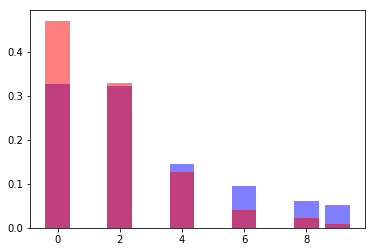

0.0026939774600629332

In [14]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [15]:
reduce_train.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
reduce_train.columns

Index(['Clip', 'Activity', 'Assessment', 'Game',
       'acc_Cart_Balancer__Assessment_', 'acc_Mushroom_Sorter__Assessment_',
       'acc_Cauldron_Filler__Assessment_', 'acc_Chest_Sorter__Assessment_',
       'acc_Bird_Measurer__Assessment_', '2050',
       ...
       'Game_duration_mean', 'Game_duration_std', 'accumulated_accuracy',
       'accuracy_group', '0', '1', '2', '3', 'accumulated_accuracy_group',
       'accumulated_actions'],
      dtype='object', length=908)

In [16]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [17]:
counter = 0
to_remove = []
# for feat_a in features:
#     for feat_b in features:
#         if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
#             if c > 0.995:
#                 counter += 1
#                 to_remove.append(feat_b)
#                 print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [18]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart_Balancer__Assessment_ -0.04020325710970116 -0.47065833333333346 0.006732930476733109
29a42aea 0.004070096099491238 0.0
dcb1663e 0.0 0.0
0ce40006 0.0008479366873940079 0.0
ecc6157f 0.007292255511588468 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
ab4ec3a4 0.0009044657998869418 0.0
2ec694de 0.008988128886376484 0.0
bfc77bd6 0.012832108535895986 0.0
17ca3959 0.0 0.0
4074bac2 0.0 0.0
003cd2ee 0.0 0.0
1b54d27f 0.0007348784624081402 0.0
a8cc6fec 0.0 0.0
611485c5 0.0013566986998304127 0.0
e4d32835 0.0013001695873374789 0.0
01ca3a3c 0.0004522328999434709 0.0
13f56524 0.04392312040700961 0.0
5dc079d8 0.0 0.0
6aeafed4 0.14703222159412097 0.008 0.0
7fd1ac25 0.01978518937252685 0.0
119b5b02 0.0002826455624646693 0.0
Sandcastle_Builder__Activity__2010 0.0 0.0
Bug_Measurer__Activity__4080 0.008988128886376484 0.0
Pan_Balance_2010 0.0 0.0
Scrub_A_Dub_4080 0.0 0.0
Dino_Drink_4080 0.0009044657998869418 0.0
Watering_Hole__Activity__2010 0.0007348784624081402 0.0
Mushroom_Sorter__Assessment__4080 

In [19]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 863)


seed : 1


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.908138	valid_1's rmse: 0.980341
[200]	training's rmse: 0.84524	valid_1's rmse: 0.978327
[300]	training's rmse: 0.796855	valid_1's rmse: 0.978625
Early stopping, best iteration is:
[168]	training's rmse: 0.862752	valid_1's rmse: 0.977455
Partial score of fold 0 is: 0.5942336087900248
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.905269	valid_1's rmse: 0.99286
[200]	training's rmse: 0.841351	valid_1's rmse: 0.991824
[300]	training's rmse: 0.793039	valid_1's rmse: 0.99426
Early stopping, best iteration is:
[126]	training's rmse: 0.885597	valid_1's rmse: 0.990999
Partial score of fold 1 is: 0.5846931651140554
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907405	valid_1's rmse: 0.987787
[200]	training's rmse: 0.843794	valid_1's rmse: 0.986648
[300]	training's rmse: 0.796131	valid_1's rmse: 0.987511
Early stopping, best itera

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.90858	valid_1's rmse: 0.981219
[200]	training's rmse: 0.84512	valid_1's rmse: 0.978441
[300]	training's rmse: 0.796618	valid_1's rmse: 0.981053
Early stopping, best iteration is:
[177]	training's rmse: 0.858077	valid_1's rmse: 0.978043
Partial score of fold 0 is: 0.5926234246979217
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.904991	valid_1's rmse: 0.991866
[200]	training's rmse: 0.841857	valid_1's rmse: 0.991465
[300]	training's rmse: 0.793864	valid_1's rmse: 0.993292
Early stopping, best iteration is:
[149]	training's rmse: 0.871845	valid_1's rmse: 0.989836
Partial score of fold 1 is: 0.584872099553903
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.905651	valid_1's rmse: 0.989962
[200]	training's rmse: 0.842775	valid_1's rmse: 0.987078
[300]	training's rmse: 0.795384	valid_1's rmse: 0.988649
Early stopping, best itera

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.908661	valid_1's rmse: 0.984117
[200]	training's rmse: 0.845213	valid_1's rmse: 0.981049
[300]	training's rmse: 0.795962	valid_1's rmse: 0.981288
[400]	training's rmse: 0.755034	valid_1's rmse: 0.98344
Early stopping, best iteration is:
[232]	training's rmse: 0.828624	valid_1's rmse: 0.980774
Partial score of fold 0 is: 0.5953070648514269
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.905117	valid_1's rmse: 0.991134
[200]	training's rmse: 0.841906	valid_1's rmse: 0.990828
[300]	training's rmse: 0.794128	valid_1's rmse: 0.991464
Early stopping, best iteration is:
[158]	training's rmse: 0.865691	valid_1's rmse: 0.988958
Partial score of fold 1 is: 0.5857667717531403
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907026	valid_1's rmse: 0.989661
[200]	training's rmse: 0.845145	valid_1's rmse: 0.98657
[300]	training's rmse: 0.

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.908143	valid_1's rmse: 0.983586
[200]	training's rmse: 0.845825	valid_1's rmse: 0.980277
[300]	training's rmse: 0.796576	valid_1's rmse: 0.979194
[400]	training's rmse: 0.755693	valid_1's rmse: 0.980494
[500]	training's rmse: 0.71944	valid_1's rmse: 0.983487
Early stopping, best iteration is:
[333]	training's rmse: 0.782969	valid_1's rmse: 0.97894
Partial score of fold 0 is: 0.6015069052907136
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.904895	valid_1's rmse: 0.991248
[200]	training's rmse: 0.842336	valid_1's rmse: 0.991434
[300]	training's rmse: 0.794135	valid_1's rmse: 0.994199
Early stopping, best iteration is:
[143]	training's rmse: 0.875036	valid_1's rmse: 0.990928
Partial score of fold 1 is: 0.5852299684335979
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907306	valid_1's rmse: 0.989901
[200]	training's rmse: 0.

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.909793	valid_1's rmse: 0.980658
[200]	training's rmse: 0.846876	valid_1's rmse: 0.978475
[300]	training's rmse: 0.79892	valid_1's rmse: 0.979429
Early stopping, best iteration is:
[167]	training's rmse: 0.865407	valid_1's rmse: 0.978079
Partial score of fold 0 is: 0.5919077873236538
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.905109	valid_1's rmse: 0.990782
[200]	training's rmse: 0.842709	valid_1's rmse: 0.990654
[300]	training's rmse: 0.794782	valid_1's rmse: 0.993929
Early stopping, best iteration is:
[170]	training's rmse: 0.859222	valid_1's rmse: 0.990032
Partial score of fold 1 is: 0.582545951835886
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907486	valid_1's rmse: 0.988529
[200]	training's rmse: 0.844433	valid_1's rmse: 0.986326
[300]	training's rmse: 0.797809	valid_1's rmse: 0.988013
Early stopping, best iter

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.908398	valid_1's rmse: 0.982287
[200]	training's rmse: 0.845384	valid_1's rmse: 0.977585
[300]	training's rmse: 0.797626	valid_1's rmse: 0.978832
Early stopping, best iteration is:
[162]	training's rmse: 0.86626	valid_1's rmse: 0.97715
Partial score of fold 0 is: 0.5945914274771589
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.904306	valid_1's rmse: 0.991507
[200]	training's rmse: 0.841882	valid_1's rmse: 0.990062
[300]	training's rmse: 0.794354	valid_1's rmse: 0.993314
Early stopping, best iteration is:
[199]	training's rmse: 0.842468	valid_1's rmse: 0.989834
Partial score of fold 1 is: 0.5803987385577165
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907093	valid_1's rmse: 0.989516
[200]	training's rmse: 0.843651	valid_1's rmse: 0.988019
[300]	training's rmse: 0.796022	valid_1's rmse: 0.989482
Early stopping, best iter

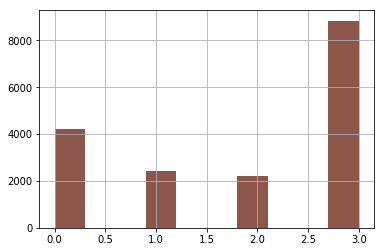

In [20]:
all_params = {'n_estimators':[10000],
              'boosting_type': ['gbdt'],
              'objective': ['regression'],
              'metric': ['rmse'],
              'subsample': [0.8],
              'subsample_freq': [1],
              'learning_rate': [0.05],
              'feature_fraction': [0.9],
              'max_depth': [13],
              "num_leaves":[25],
              'lambda_l1': [1],  
              'lambda_l2': [1],
              'early_stopping_rounds': [200],
              "seed":[1,2,3,4,5,6]
             }

for params in tqdm(list(ParameterGrid(all_params))):
    if params["seed"] == 1:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_1 = Lgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
        
    elif params["seed"] == 2:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_2 = Lgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
        
    elif params["seed"] == 3:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_3 = Lgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
    
    elif params["seed"] == 4:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_4 = Lgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
        
    elif params["seed"] == 5:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_5 = Lgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
    
    elif params["seed"] == 6:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_6 = Lgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)


seed : 1


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80549	val-rmse:1.80505
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.90724	val-rmse:0.986908
[200]	train-rmse:0.855534	val-rmse:0.984227
[300]	train-rmse:0.817894	val-rmse:0.984923
[400]	train-rmse:0.780861	val-rmse:0.986021
Stopping. Best iteration:
[225]	train-rmse:0.846381	val-rmse:0.983873

Partial score of fold 0 is: 0.5847514135809734
[0]	train-rmse:1.80536	val-rmse:1.80669
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.904443	val-rmse:0.992106
[200]	train-rmse:0.85191	val-rmse:0.990636
[300]	train-rmse:0.812123	val-rmse:0.993055
Stopping. Best iteration:
[145]	train-rmse:0.875762	val-rmse:0.990499

Partial score of fold 1 is: 0.5812934107569538
[0]	train-rmse:1.80542	val-rmse:1.80608
Multiple eval metrics have been passed: 'val-rmse' wil

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.81336	val-rmse:1.81412
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.906782	val-rmse:0.98848
[200]	train-rmse:0.852653	val-rmse:0.98498
[300]	train-rmse:0.810916	val-rmse:0.984902
[400]	train-rmse:0.775477	val-rmse:0.98537
Stopping. Best iteration:
[215]	train-rmse:0.844459	val-rmse:0.984347

Partial score of fold 0 is: 0.5849303229245404
[0]	train-rmse:1.81365	val-rmse:1.81491
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.90448	val-rmse:0.992399
[200]	train-rmse:0.854283	val-rmse:0.990181
[300]	train-rmse:0.813944	val-rmse:0.991501
Stopping. Best iteration:
[183]	train-rmse:0.861398	val-rmse:0.989935

Partial score of fold 1 is: 0.582545951835886
[0]	train-rmse:1.81354	val-rmse:1.81373
Multiple eval metrics have been passed: 'val-rmse' will b

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80548	val-rmse:1.80514
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.906053	val-rmse:0.985386
[200]	train-rmse:0.851765	val-rmse:0.981069
[300]	train-rmse:0.811056	val-rmse:0.980977
[400]	train-rmse:0.777512	val-rmse:0.983062
Stopping. Best iteration:
[253]	train-rmse:0.828896	val-rmse:0.980394

Partial score of fold 0 is: 0.5867194163602105
[0]	train-rmse:1.80536	val-rmse:1.80676
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.903457	val-rmse:0.991457
[200]	train-rmse:0.847995	val-rmse:0.988874
[300]	train-rmse:0.807767	val-rmse:0.990246
[400]	train-rmse:0.771518	val-rmse:0.992433
Stopping. Best iteration:
[219]	train-rmse:0.839817	val-rmse:0.988475

Partial score of fold 1 is: 0.5812934107569538
[0]	train-rmse:1.80541	val-rmse:1.8061
Multiple 

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80547	val-rmse:1.80524
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.906137	val-rmse:0.985466
[200]	train-rmse:0.855516	val-rmse:0.981304
[300]	train-rmse:0.814175	val-rmse:0.981551
Stopping. Best iteration:
[175]	train-rmse:0.865889	val-rmse:0.980604

Partial score of fold 0 is: 0.5906554219186846
[0]	train-rmse:1.80535	val-rmse:1.80679
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.902961	val-rmse:0.993036
[200]	train-rmse:0.853461	val-rmse:0.992095
[300]	train-rmse:0.813594	val-rmse:0.992812
[400]	train-rmse:0.776798	val-rmse:0.995709
Stopping. Best iteration:
[230]	train-rmse:0.84106	val-rmse:0.991467

Partial score of fold 1 is: 0.575030705362293
[0]	train-rmse:1.80541	val-rmse:1.8061
Multiple eval metrics have been passed: 'val-rmse' will

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80548	val-rmse:1.80528
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.905191	val-rmse:0.986204
[200]	train-rmse:0.852146	val-rmse:0.980759
[300]	train-rmse:0.810289	val-rmse:0.981831
Stopping. Best iteration:
[197]	train-rmse:0.853697	val-rmse:0.98048

Partial score of fold 0 is: 0.5867194163602105
[0]	train-rmse:1.8056	val-rmse:1.80699
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.904251	val-rmse:0.992793
[200]	train-rmse:0.849102	val-rmse:0.989555
[300]	train-rmse:0.809211	val-rmse:0.990997
Stopping. Best iteration:
[160]	train-rmse:0.867341	val-rmse:0.989059

Partial score of fold 1 is: 0.5791461974787844
[0]	train-rmse:1.80542	val-rmse:1.80613
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train un

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.81337	val-rmse:1.81412
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.906134	val-rmse:0.98551
[200]	train-rmse:0.853999	val-rmse:0.981908
[300]	train-rmse:0.812049	val-rmse:0.982317
Stopping. Best iteration:
[194]	train-rmse:0.856482	val-rmse:0.981836

Partial score of fold 0 is: 0.5861826883295094
[0]	train-rmse:1.81365	val-rmse:1.81475
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.903183	val-rmse:0.992388
[200]	train-rmse:0.851186	val-rmse:0.990166
[300]	train-rmse:0.810825	val-rmse:0.991481
Stopping. Best iteration:
[158]	train-rmse:0.87094	val-rmse:0.989814

Partial score of fold 1 is: 0.5818302140764962
[0]	train-rmse:1.81367	val-rmse:1.81423
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train un

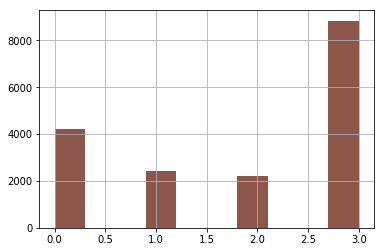

In [21]:
all_params = {'colsample_bytree': [0.8],                 
              'learning_rate': [0.05],
              'max_depth': [5],
              'subsample': [1],
              "alpha":[1e-5],
              'objective':['reg:squarederror'],
              'min_child_weight':[2],
              'gamma':[0],
              'n_estimators':[10000],
              "seed":[1,2,3,4,5,6]
             }

for params in tqdm(list(ParameterGrid(all_params))):
    if params["seed"] == 1:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_1 = Xgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
        
    elif params["seed"] == 2:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_2 = Xgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
        
    elif params["seed"] == 3:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_3 = Xgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
    
    elif params["seed"] == 4:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_4 = Xgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
        
    elif params["seed"] == 5:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_5 = Xgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)
    
    elif params["seed"] == 6:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_6 = Xgb_Model(reduce_train, ajusted_test, features, params, categoricals=categoricals)

In [22]:
lgb_en = (lgb_model_1.y_pred + lgb_model_2.y_pred + lgb_model_3.y_pred + lgb_model_4.y_pred + lgb_model_5.y_pred + lgb_model_6.y_pred) / 6
xgb_en = (xgb_model_1.y_pred + xgb_model_2.y_pred + xgb_model_3.y_pred + xgb_model_4.y_pred + xgb_model_5.y_pred + xgb_model_6.y_pred) / 6

In [23]:
weights = {'lbg': 0.80, 'cat': 0, 'xgb': 0.20, 'nn': 0.00}

final_pred_1 = (lgb_en * weights['lbg']) + (xgb_en * weights['xgb'])
#final_pred = cnn_model.y_pred
print(final_pred_1.shape)

(1000,)


In [24]:
#pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [26]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        model = None
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        self.oof_pred = oof_pred
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

    def set_params(self, params):
        self.params = params

    def retrain(self):
        self.cv = self.get_cv()
        self.y_pred, self.score, self.model = self.fit()

In [27]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
    
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
   
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 1000
                    }
        return params

In [28]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=1000)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 1.03391	valid_1's rmse: 1.05256
[200]	training's rmse: 0.965962	valid_1's rmse: 1.00382
[300]	training's rmse: 0.931325	valid_1's rmse: 0.987031
[400]	training's rmse: 0.907023	valid_1's rmse: 0.980454
[500]	training's rmse: 0.887367	valid_1's rmse: 0.977662
[600]	training's rmse: 0.870093	valid_1's rmse: 0.975918
[700]	training's rmse: 0.854778	valid_1's rmse: 0.975197
[800]	training's rmse: 0.840408	valid_1's rmse: 0.974306
[900]	training's rmse: 0.827074	valid_1's rmse: 0.974496
[1000]	training's rmse: 0.814465	valid_1's rmse: 0.974137
[1100]	training's rmse: 0.802422	valid_1's rmse: 0.973946
[1200]	training's rmse: 0.790743	valid_1's rmse: 0.974012
[1300]	training's rmse: 0.779499	valid_1's rmse: 0.974042
[1400]	training's rmse: 0.768882	valid_1's rmse: 0.974302
[1500]	training's rmse: 0.758535	valid_1's rmse: 0.974625
[1600]	training's rmse: 0.748647	valid_1's rmse: 0.975049
[1700]	training's rms

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.85623	val-rmse:1.85704
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 1000 rounds.
[100]	train-rmse:1.00333	val-rmse:1.15298
[200]	train-rmse:0.729944	val-rmse:1.016
[300]	train-rmse:0.614399	val-rmse:0.994781
[400]	train-rmse:0.552457	val-rmse:0.991651
[500]	train-rmse:0.512932	val-rmse:0.991751
[600]	train-rmse:0.482081	val-rmse:0.992292
[700]	train-rmse:0.456164	val-rmse:0.992664
[800]	train-rmse:0.435624	val-rmse:0.99287
[900]	train-rmse:0.417524	val-rmse:0.993754
[1000]	train-rmse:0.400607	val-rmse:0.994234
[1100]	train-rmse:0.383822	val-rmse:0.994752
[1200]	train-rmse:0.37071	val-rmse:0.995328
[1300]	train-rmse:0.358311	val-rmse:0.995645
[1400]	train-rmse:0.34468	val-rmse:0.996427
Stopping. Best iteration:
[414]	train-rmse:0.545227	val-rmse:0.991421

Partial score of fold 0 is: 0.5838568668631383
[0]	train-rmse:1.85618	val-rmse:1.85755
Multiple eval metrics have been passed: 'val-r

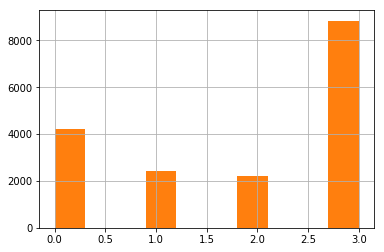

In [29]:
#cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [30]:
session_title1 = reduce_train['session_title'].value_counts().index[0]
session_title2 = reduce_train['session_title'].value_counts().index[1]
session_title3 = reduce_train['session_title'].value_counts().index[2]
session_title4 = reduce_train['session_title'].value_counts().index[3]
session_title5 = reduce_train['session_title'].value_counts().index[4]

reduce_train['session_title'] = reduce_train['session_title'].replace({session_title1:0,session_title2:1,session_title3:2,session_title4:3,session_title5:4})
reduce_test['session_title'] = reduce_test['session_title'].replace({session_title1:0,session_title2:1,session_title3:2,session_title4:3,session_title5:4})

In [31]:
for col in reduce_train.columns:
    if type(col) != str:
        reduce_train = reduce_train.rename(columns={col:str(col)})
        reduce_test = reduce_test.rename(columns={col:str(col)})

col_order = sorted(reduce_train.columns)
reduce_train = reduce_train.ix[:,col_order]
reduce_test = reduce_test.ix[:,col_order]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [32]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']
target_enc_cols = ['session_title','Game']
categoricals = ['session_title']

In [33]:
clparams   = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 
            'bagging_fraction_seed': 127,
            'feature_fraction_seed': 127,
            'data_random_seed': 127,
            'seed':127
            }

In [34]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
import time
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
n_fold = 5
folds = GroupKFold(n_splits=n_fold)
X = reduce_train.copy()
cl_y = reduce_train['accuracy_group'].copy()
# cl_y.loc[cl_y>0]=1
cols_to_drop = ['installation_id','accuracy_group']
cl_oof = np.zeros(len(reduce_train))
models = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, cl_y, X['installation_id'])):
    print('Fold {} started at {}'.format(fold_n+1,time.ctime()))
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = cl_y.iloc[train_index], cl_y.iloc[valid_index]
    
    X_train = X_train.drop(cols_to_drop,axis=1)
    X_valid = X_valid.drop(cols_to_drop,axis=1)
    
    trn_data = lgb.Dataset(X_train,label=y_train)
    val_data = lgb.Dataset(X_valid,label=y_valid)
    
    cl_lgb_model = lgb.train(clparams,
                        trn_data,
                        valid_sets=[trn_data,val_data],
                        verbose_eval=100,
                        categorical_feature = categoricals
                        )
    pred = cl_lgb_model.predict(X_valid)
    models.append(cl_lgb_model)
    cl_oof[valid_index] = pred

Fold 1 started at Wed Jan 22 18:34:27 2020


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['session_title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.914974	valid_1's auc: 0.858995
[200]	training's auc: 0.946836	valid_1's auc: 0.8615
[300]	training's auc: 0.965651	valid_1's auc: 0.861117
Early stopping, best iteration is:
[213]	training's auc: 0.9497	valid_1's auc: 0.862219
Fold 2 started at Wed Jan 22 18:34:54 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.914392	valid_1's auc: 0.855914
[200]	training's auc: 0.946087	valid_1's auc: 0.856378
Early stopping, best iteration is:
[174]	training's auc: 0.939235	valid_1's auc: 0.858087
Fold 3 started at Wed Jan 22 18:35:21 2020
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.915464	valid_1's auc: 0.849422
[200]	training's auc: 0.946236	valid_1's auc: 0.852181
[300]	training's auc: 0.964356	valid_1's auc: 0.851238
Early stopping, best iteration is:
[207]	training's auc: 0.948017	valid_1's auc: 0.852692
Fold 4 started at Wed 

Our oof cohen kappa score is:  0.5710873995114178


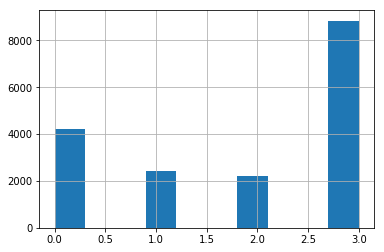

In [35]:
# print('cappe ',roc_auc_score(cl_y,cl_oof))
_, loss_score, _ = eval_qwk_lgb_regr(cl_y, cl_oof)
print('Our oof cohen kappa score is: ', loss_score)

In [36]:
def cl_predict(test,models):
    all_ans = np.zeros((len(test)))
    cols_to_drop = ['installation_id','accuracy_group']
    test_copy = test.drop(cols_to_drop,axis=1)
    for model in models:
        ans = model.predict(test_copy)
        all_ans += ans
        
    return all_ans/n_fold

In [37]:
def cl_predict(test, models):
    all_ans = np.zeros((len(test)))
    cols_to_drop = ['installation_id','accuracy_group']
    test_copy = test.drop(cols_to_drop,axis=1)
    for model in models:
        ans = model.predict(test_copy)
        all_ans += ans
        
    return all_ans/n_fold

In [38]:
class_pred = cl_predict(reduce_test, models)

In [39]:
def Weight_Bayesian(w_lgb):
    w_xgb = 1.0 - w_lgb
    combine_oof_pred = w_lgb * lgb_model.oof_pred + w_xgb * xgb_model.oof_pred
    score = eval_qwk_lgb_regr(reduce_train['accuracy_group'], combine_oof_pred)
    print('weighted score equals {}'.format(score))
    return score

weighted score equals ('cappa', 0.5743443293048476, True)
step 0
weighted score equals ('cappa', 0.5743443293048476, True)
step 1
weighted score equals ('cappa', 0.5745232814912997, True)
step 2
weighted score equals ('cappa', 0.5749527667387849, True)
step 3
weighted score equals ('cappa', 0.575203299799818, True)
step 4
weighted score equals ('cappa', 0.5754538328608511, True)
step 5
weighted score equals ('cappa', 0.5762770129185311, True)
step 6
weighted score equals ('cappa', 0.5766707077287259, True)
step 7
weighted score equals ('cappa', 0.5769928216643398, True)
step 8
weighted score equals ('cappa', 0.5769928216643398, True)
step 9
weighted score equals ('cappa', 0.5773149355999536, True)
step 10
weighted score equals ('cappa', 0.5779591634711816, True)
step 11
weighted score equals ('cappa', 0.5782454869695051, True)
step 12
weighted score equals ('cappa', 0.5786033913424093, True)
step 13
weighted score equals ('cappa', 0.5788897148407328, True)
step 14
weighted score equals

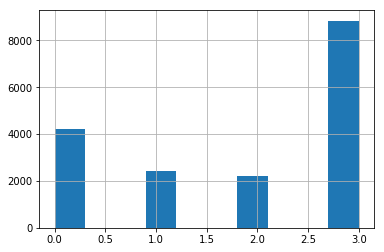

In [40]:
def random_search(start, end, step=0.1):
    itera = 0
    max_w = start
    max_score = Weight_Bayesian(max_w)
    while start <= end:
        print('step {}'.format(itera))
        score = Weight_Bayesian(start)
        if score > max_score:
            max_w = start
            max_score = score
        start += step
        itera += 1
    print('max weight: lgb{} xgb{}'.format(max_w, 1 - max_w))
    print('max weighted score equals {}'.format(score))
    return max_w
    
w_lgb = random_search(0.0, 1.0, step=0.01)

In [41]:
rg_oof = w_lgb * lgb_model.oof_pred + (1 - w_lgb) * xgb_model.oof_pred

In [42]:
# weights = {'lbg': 0.78, 'cat': 0, 'xgb': 0.22, 'nn': 0}
weights = {'lbg': w_lgb, 'cat': 0, 'xgb': 1 - w_lgb, 'nn': 0}

# final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb'])
print(final_pred.shape)

(1000,)


In [43]:
def Weight_Rgs(w_rgs):
    w_cls = 1.0 - w_rgs
    combine_oof_pred = w_rgs * rg_oof + w_cls * cl_oof
    score = eval_qwk_lgb_regr(reduce_train['accuracy_group'], combine_oof_pred)
    print('weighted score equals {}'.format(score))
    return score

weighted score equals ('cappa', 0.5710873995114178, True)
step 0
weighted score equals ('cappa', 0.5710873995114178, True)
step 1
weighted score equals ('cappa', 0.5736643109963293, True)
step 2
weighted score equals ('cappa', 0.5763485937931119, True)
step 3
weighted score equals ('cappa', 0.5786391817796999, True)
step 4
weighted score equals ('cappa', 0.5812160932646112, True)
step 5
weighted score equals ('cappa', 0.5826835011935191, True)
step 6
weighted score equals ('cappa', 0.5843656517461695, True)
step 7
weighted score equals ('cappa', 0.5853677839903018, True)
step 8
weighted score equals ('cappa', 0.5866562397327575, True)
step 9
weighted score equals ('cappa', 0.5878731146006322, True)
step 10
weighted score equals ('cappa', 0.5883383902854079, True)
step 11
weighted score equals ('cappa', 0.5898773790888967, True)
step 12
weighted score equals ('cappa', 0.5908437208957384, True)
step 13
weighted score equals ('cappa', 0.5917742722652897, True)
step 14
weighted score equal

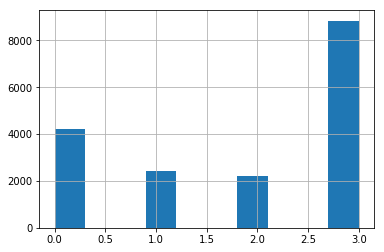

In [44]:
def random_search(start, end, step=0.1):
    itera = 0
    max_w = start
    max_score = Weight_Rgs(max_w)
    while start <= end:
        print('step {}'.format(itera))
        score = Weight_Rgs(start)
        if score > max_score:
            max_w = start
            max_score = score
        start += step
        itera += 1
    print('max weight: regression{} classification{}'.format(max_w, 1 - max_w))
    print('max weighted score equals {}'.format(score))
    return max_w

w_rgs = random_search(0.0, 1.0, step=0.01)

In [45]:
final_pred_2 = w_rgs * final_pred + (1 - w_rgs) * class_pred

In [46]:
final_pred = (final_pred_1 + final_pred_2) / 2

{0: 1.201878488449891, 1: 1.5623355316603322, 2: 1.783343376164284}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

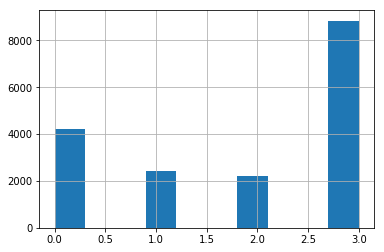

In [47]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)